Questions

1.	How would you measure the business impact of your model?
2.	Describe how you would use your model in a business setting.
3.	Plot the predicted close rate as a function of lead age.
4.	What problems do you foresee when retraining the model a year from now? (We’re interested in biases that might creep into the data.)
5.	Extra credit: How might you improve upon the greedy method of ranking leads based on predicted close rate? (We have an idea but we don’t know if it’s practical!)


Data Dictionary

-	lead_id: (self-explanatory)
-	funded: Did the lead convert to a funded loan? (target variable; binary)
-	created_datetime: (self-explanatory)
-	assignment_datetime: Datetime when the lead is assigned to a salesperson
-	loan_to_income: Ratio of loan amount to income, stated as a percentage
-	co_app_income: Income of co-applicant (if any)
-	job_status: (self-explanatory)
-	fico_score: Industry standard credit-worthiness score (higher is better)
-	loan_amount: (self-explanatory)
-	loan_use: (self-explanatory)
-	ndi_ratio: Ratio of total debt service to income
-	lead_source: Marketing channel where lead originated
-	open_accounts: Number of active credit accounts
-	clicked_offer: Did the user click our ad? (…or did they simply view it? binary)


In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, fbeta_score, classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns




/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# read data
dir = 'DSHomework-LeadScoring'
file = 'DS Homework - Lead Scoring.csv'
df = pd.read_csv(f'./{dir}/{file}')

In [3]:
df.iloc[:3,:]

,lead_id,funded,created_datetime,assignment_datetime,loan_to_income,co_app_income,job_status,fico_score,loan_amount,loan_use,ndi_ratio,lead_source,open_accounts,clicked_offer
0,7599355,0,2021-09-11 17:42:44+00:00,2021-09-11 17:48:47+00:00,24.621212,0.0,Part-Time,668,32500,Debt Consolidation,0.232132,0,8,0
1,7600116,0,2021-09-11 21:57:35+00:00,2021-09-12 07:59:24+00:00,20.000000,0.0,Not Employed,792,40000,Other,0.146557,0,6,0
2,7599525,0,2021-09-11 18:29:20+00:00,2021-09-12 07:32:12+00:00,27.272727,0.0,Full-Time,755,30000,Home Improvement,0.510868,0,5,0


In [4]:
print(f'number of rows {df.shape[0]} number of unique leads {len( df.lead_id.unique())}')
leads = list(df.lead_id)
non_unique_leads = [k for k, v in Counter(leads).items() if v > 1]
print(f'Non unique leads {non_unique_leads}')
print(df.loc[df.lead_id.isin(non_unique_leads)])

number of rows 125322 number of unique leads 125320
Non unique leads [7211526, 7309496]
       lead_id  funded           created_datetime        assignment_datetime  \
61804  7211526       0  2021-07-23 08:06:25+00:00  2021-07-23 08:43:05+00:00   
61805  7211526       0  2021-07-23 08:06:25+00:00  2021-07-23 08:43:05+00:00   
79202  7309496       0  2021-08-04 20:30:05+00:00  2021-08-13 18:28:51+00:00   
79203  7309496       0  2021-08-04 20:30:05+00:00  2021-08-13 18:28:51+00:00   

       loan_to_income  co_app_income job_status  fico_score  loan_amount  \
61804       34.897959            0.0  Full-Time         731        17100   
61805       34.897959            0.0  Full-Time         731        17100   
79202       10.416667            0.0  Full-Time         621        50000   
79203       10.416667            0.0  Full-Time         621        50000   

                      loan_use  ndi_ratio  lead_source  open_accounts  \
61804  Credit Card Refinancing   0.697691            8   

In [5]:
# so those are repeated rows; let's drop them.
# df.drop_duplicates(inplace=True)

In [6]:
# more data quality; check for Nan's
# df.isnull().any().any()

In [7]:
# feature engineering
def feature_engineering(df):
    df.drop_duplicates(inplace=True)
    # manage dates
    df['date_delta']=(pd.to_datetime(df['assignment_datetime'])-pd.to_datetime(df['created_datetime'])).dt.total_seconds()
    df.drop(['assignment_datetime','created_datetime','lead_id'],axis=1,inplace=True)
    df=pd.get_dummies(df,columns=['job_status','loan_use'], drop_first=True)
    return(df)
df = feature_engineering(df)

### Data exploration

In [9]:
df.columns
noplots = ['job_status','loan_use',]
showplots = [item for item in df.columns if '_'.join(item.split('_')[:2]) not in noplots]

In [15]:

df_plot = df[showplots].sample(n=10000, random_state=1)

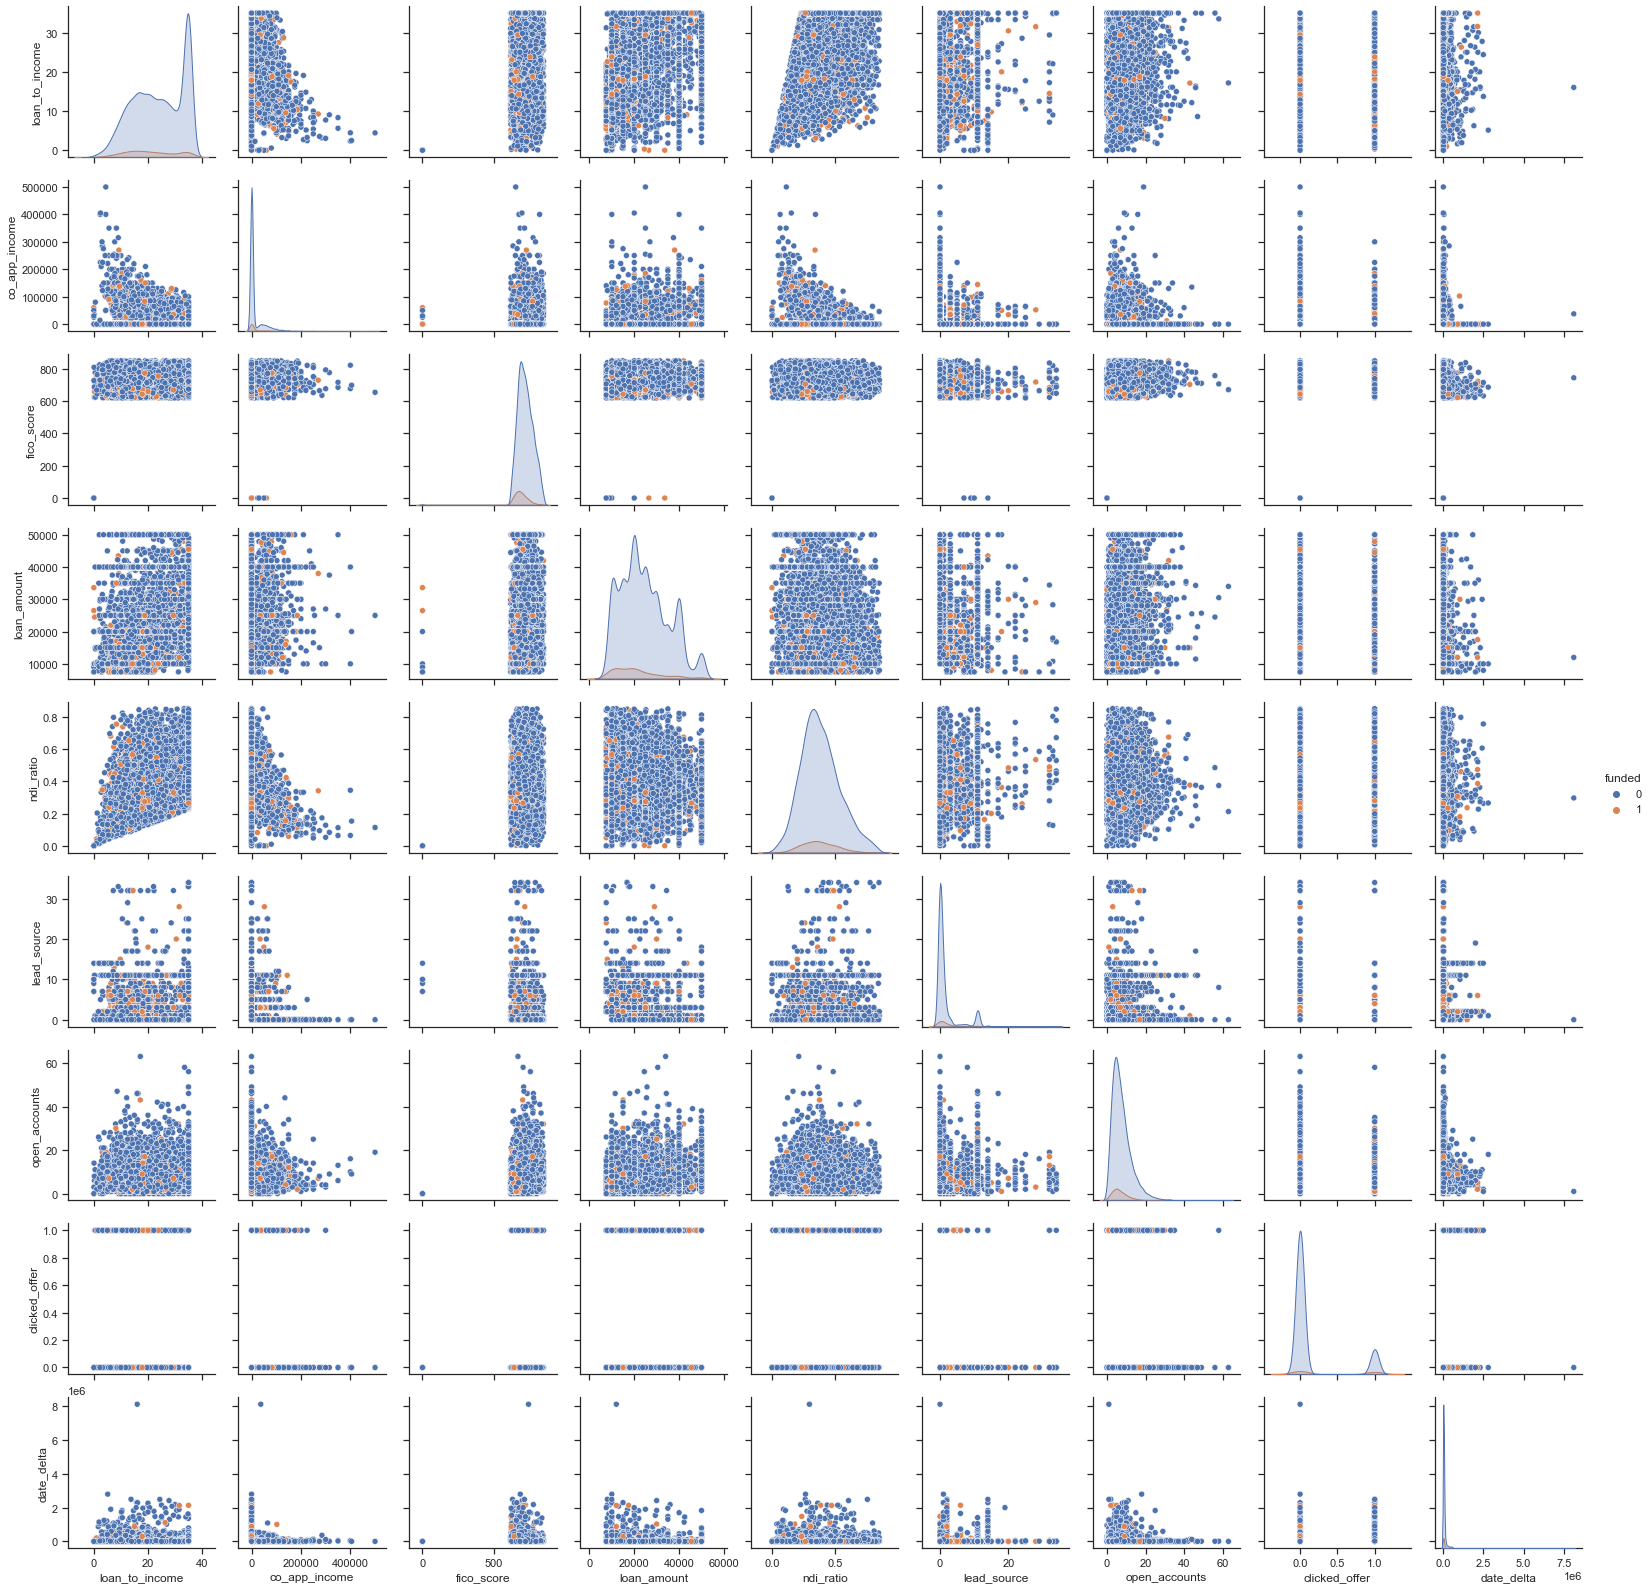

In [16]:
sns.set(style="ticks", color_codes=True)
#iris = sns.load_dataset("iris")
g = sns.pairplot(df_plot,hue='funded')

#### No obvious non-linear features to add.

### Baseline ML Models

In [17]:
# a few simple baseline models
y = df.pop('funded')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [18]:
# logistic regression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

predictions = logisticRegr.predict(X_test)
acc = accuracy_score(y_test, predictions.round())
auc = roc_auc_score(y_test, predictions.round())
f1 = f1_score(y_test, predictions.round())
print(f'acc:{acc:.2f} auc:{auc:.2f} f1:{f1:.2f}')

redon  = '\033[91m'
redoff = '\033[0m'
print(f'{redon}Well, that didn\'t work{redoff}')

acc:0.93 auc:0.50 f1:0.00
Well, that didn't work


In [19]:
# xgboost
xgbClass = XGBClassifier(use_label_encoder=False)
xgbClass.fit(X_train, y_train)
print(xgbClass)
predictions = xgbClass.predict_proba(X_test)[:,1]
predictions_int = [int(i) for i in predictions.round()]

acc = accuracy_score(y_test, predictions_int)
auc = roc_auc_score(y_test, predictions_int)
f1 = f1_score(y_test, predictions_int)
print(f'acc:{acc:.2f} auc:{auc:.2f} f1:{f1:.2f}')
print(confusion_matrix(y_test,predictions_int))
print(classification_report(y_test,predictions_int))

[14:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
acc:0.93 auc:0.51 f1:0.05
[[29067    78]
 [ 2125    60]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     29145
           1       0.43      0.03      0.05      2185

    accuracy                           0.93     31330
   macro avg       0.68      0.51      0.51    

In [20]:
# xgb with weighting
def wgt(n_pos,n_neg):
    if (n_pos>0 and n_neg>0):
        return(n_neg/n_pos)
    else:
        return(1)
scale_pos_weight =wgt(sum(y_train),len(y_train)-sum(y_train)) 

In [21]:
xgbClass = XGBClassifier(use_label_encoder=False,eval_metric='auc',scale_pos_weight=scale_pos_weight)

xgbClass.fit(X_train, y_train)
predictions = xgbClass.predict_proba(X_test)[:,1]
predictions_int = [int(i) for i in predictions.round()]

acc = accuracy_score(y_test, predictions_int)
auc = roc_auc_score(y_test, predictions_int)
f1 = f1_score(y_test, predictions_int)
print(f'acc:{acc:.2f} auc:{auc:.2f} f1:{f1:.2f}')
print(confusion_matrix(y_test,predictions_int))
print(classification_report(y_test,predictions_int))


/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


acc:0.78 auc:0.69 f1:0.27
[[23072  6073]
 [  886  1299]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     29145
           1       0.18      0.59      0.27      2185

    accuracy                           0.78     31330
   macro avg       0.57      0.69      0.57     31330
weighted avg       0.91      0.78      0.83     31330



### Can we do better?  Hyperparameter Tuning

In [22]:
xgbClass = XGBClassifier(use_label_encoder=False,eval_metric='auc',scale_pos_weight=scale_pos_weight)

#
# Create the parameter grid
#
param_grid_xgb = [{
    'scale_pos_weight':[1, 3, scale_pos_weight, 24],
    'max_depth':[5,8,12],
    'min_child_weight':[1,4,8]
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsXGB = GridSearchCV(estimator=xgbClass,
                     param_grid = param_grid_xgb,
                     scoring='f1',
                     cv=10,
                     refit=True,
                     n_jobs=1)

In [23]:
#
# Train the RandomForestClassifier
#
gsXGB = gsXGB.fit(X_train, y_train)

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gary/.virtualenvs/freedomfinancial-SsHr

In [24]:
#
# Print the training score of the best model
#
print(gsXGB.best_score_)
#
# Print the model parameters of the best model
#
print(gsXGB.best_params_)
#
# Print the test score of the best model
#
clfXGB = gsXGB.best_estimator_
print('Test accuracy: %.3f' % clfXGB.score(X_test, y_test))

0.28595394787718176
{'max_depth': 8, 'min_child_weight': 4, 'scale_pos_weight': 12.79973572162678}
Test accuracy: 0.817


In [25]:
clfXGB#.score

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=12.79973572162678,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [28]:
xgbClass = XGBClassifier(use_label_encoder=False,eval_metric='auc',scale_pos_weight=scale_pos_weight,min_child_weight=4,max_depth=8)

xgbClass.fit(X_train, y_train, )
predictions = xgbClass.predict_proba(X_test)[:,1]
predictions_int = [int(i) for i in predictions.round()]

acc = accuracy_score(y_test, predictions_int)
auc = roc_auc_score(y_test, predictions_int)
f1 = f1_score(y_test, predictions_int)
print(f'acc:{acc:.2f} auc:{auc:.2f} f1:{f1:.2f}')
print(confusion_matrix(y_test,predictions_int))
print(classification_report(y_test,predictions_int))



/Users/gary/.virtualenvs/freedomfinancial-SsHr21ew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


acc:0.82 auc:0.67 f1:0.28
[[24494  4651]
 [ 1094  1091]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     29145
           1       0.19      0.50      0.28      2185

    accuracy                           0.82     31330
   macro avg       0.57      0.67      0.59     31330
weighted avg       0.90      0.82      0.85     31330



### Not really loving my model, but let's keep moving!

I'm not really impressed by the AUC and f1 scores.  Basically, our ranking is able to order two leads only about 2/3 of the time (AUC = 67%). At the same time, if you look at the scatter plots above, how can it do a whole lot better?  The positive class is scattered all over the in every plot.  

## 1. How would you measure the business impact of your model?



## 2. Describe how you would use your model in a business setting.

## 3. Plot the predicted close rate as a function of lead age.

So, what does age look like (convert to days)

<AxesSubplot:>

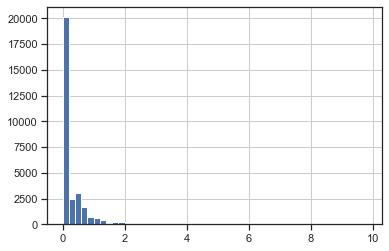

In [72]:
#(X_test.date_delta/(24*60*60)).hist(bins = range(0,200000,10000))
(X_test.date_delta/(24*60*60)).hist(bins = np.arange(0,10,0.2))

In [74]:
# combine elements of two data frames we need for the analysis (also add in ground truth for sanity check)
df_pred = pd.DataFrame(predictions, columns = ['prediction'])
# put date delta in days for readability
df1 = pd.concat([X_test.date_delta/(24*60*60), y_test], axis=1)
df1 = pd.concat([df1.reset_index(drop=True), df_pred], axis=1)

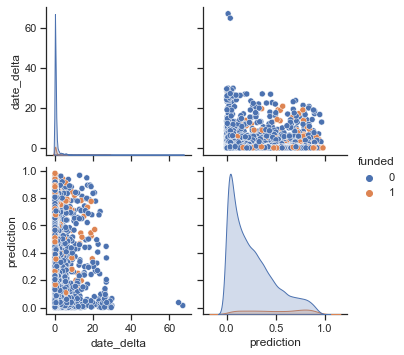

In [76]:
g = sns.pairplot(df1,hue='funded')

#### We have two non-funded outliers at 60+ days; let's just look at the range up to about 30 days.

Let's plot what was asked for, the predicted close rate (i.e. sum of prediction / number in a given bin), but we can also plot the actual close rate as a function of date_delta.

Here's how to interpret this plot.  On the horizontal axis, we have lead age, and on the vertical axis we plot in blue the average prediction of our model; in green is the average of actual conversion.  

We note that the model overpredicts this value compared to ground truth.  This is because of class imbalance.  We can see this in the confusion matrix above:

- [TN = 23072  FP = 6073]
-  [ FN = 886  TP = 1299]


but remember that the score is not normalized to be replicate this average, it's a ranking model which optimizes the AUC.  So the shapes should be similar, but the scale is likely not to match well, which is roughly true.  The predbinary (orange) column is based on a cutoff of >0.5 for the probability and matches the funded plot better.  If there is a single value to look at for the predicted conversion rate as a function of lead age, it is the predbinary (orange) data. 

<AxesSubplot:xlabel='lead_age_days', ylabel='mean'>

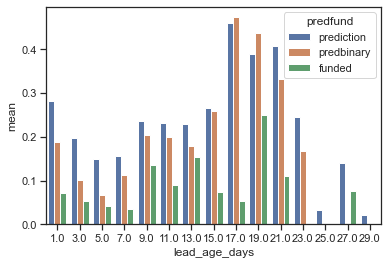

In [133]:
wid = 2
bins = np.arange(0, 30+wid, wid)
binmid = bins[:-1]+wid/2
df1['predbinary'] = df1['prediction']>0.5
gb_date=df1[['prediction','predbinary','funded']].groupby(pd.cut(df1['date_delta'], bins)).mean()
df_by_date = pd.concat([pd.DataFrame(binmid, columns = ['lead_age_days']), gb_date.reset_index(drop=True),], axis=1)
df_melt = df_by_date.melt('lead_age_days',var_name='predfund',value_name='mean')
sns.barplot(x = 'lead_age_days', y='mean', data=df_melt, hue='predfund')

## 4. What problems do you foresee when retraining the model a year from now? (We’re interested in biases that might creep into the data.)

## 5. Extra credit: How might you improve upon the greedy method of ranking leads based on predicted close rate? (We have an idea but we don’t know if it’s practical!)